In [21]:
# python based
import tensorflow as tf
# print("tensorflow version:",tf.__version__)
# print("tf.keras version:",tf.keras.__version__)

from pathlib import Path
import time
import shutil
import random
import os
import pandas as pd
import numpy as np
from tensorflow.keras.optimizers import Adam, Nadam
import matplotlib.pyplot as plt

# custom 
from loss import *
from omodels import * # This model does not have any regulariers (uses mdmmm for that)
from OptimizedDataGenerator import OptimizedDataGenerator
import mdmm

In [22]:
# dataset_path = '/depot/cms/users/dkondra/smart-pixels/dataset8/unflipped-positive'
dataset_path = '/depot/cms/users/das214/dataset8/unflipped'
data_directory_path = os.path.join(dataset_path, 'recon3D/')
labels_directory_path = os.path.join(dataset_path, 'labels/')

data_files_path_list = [os.path.join(data_directory_path, f) for f in os.listdir(data_directory_path)]
labels_files_path_list = [os.path.join(labels_directory_path, f) for f in os.listdir(labels_directory_path)]

data_files_path_list = np.sort(data_files_path_list)
labels_files_path_list = np.sort(labels_files_path_list)

print(data_directory_path)
print(labels_directory_path)
print(len(data_files_path_list))
print(len(labels_files_path_list))

/depot/cms/users/das214/dataset8/unflipped/recon3D/
/depot/cms/users/das214/dataset8/unflipped/labels/
160
160


In [23]:
output_directory = Path("./").resolve()

batch_size = 5000
val_batch_size = 5000
train_file_size = 142
val_file_size = 6
epochs=1000

model_fingerprint = '076ea794'
# model_fingerprint = '49ccb850'

In [25]:
epsilon = 1e-3
def calculate_sparsity(model, epsilon):
    zero_count = 0
    total_count = 0
    for layer in model.layers:
        if layer.weights:
            weights = layer.get_weights()[0]
            zero_count += np.sum(np.isclose(weights, 0, atol=epsilon))
            total_count += weights.size
    return zero_count / total_count if total_count > 0 else 0

def prune_weights(model, epsilon=1e-3):
    new_weights = []
    masks = []
    for weight in model.trainable_weights:
        weight_array = weight.numpy()
        mask = np.abs(weight_array) >= epsilon
        pruned_weights = weight_array * mask
        new_weights.append(pruned_weights)
        masks.append(mask)
    return new_weights, masks

class RigidPrunedModel(tf.keras.Model):
    def __init__(self, base_model, masks):
        super(RigidPrunedModel, self).__init__()
        self.base_model = base_model
        self.masks = masks

    def save_weights(self, filepath, overwrite=True, save_format=None, options=None):
        self.base_model.save_weights(filepath, overwrite, save_format, options)

    def load_weights(self, filepath, by_name=False, skip_mismatch=False, options=None):
        self.base_model.load_weights(filepath, by_name, skip_mismatch, options)
        
    def call(self, inputs):
        return self.base_model(inputs)

    def train_step(self, data):
        x, y = data

        with tf.GradientTape() as tape:
            predictions = self.call(x)
            loss = self.compiled_loss(y, predictions)

        gradients = tape.gradient(loss, self.trainable_weights)
        for i, (grad, mask) in enumerate(zip(gradients, self.masks)):
            gradients[i] *= mask  # Apply mask to keep pruned weights zero

        self.optimizer.apply_gradients(zip(gradients, self.trainable_weights))

        # Enforce mask to keep the zero weights strictly zero
        for i, mask in enumerate(self.masks):
            pruned_weights = self.trainable_weights[i] * mask
            self.trainable_weights[i].assign(pruned_weights)
            
        self.compiled_metrics.update_state(y, predictions)
        return {m.name: m.result() for m in self.metrics}

    def get_config(self):
        model_config = self.model.get_config()
        config = super().get_config()
        config.update({
            "base_model":model_config,
        })

    @classmethod
    def from_config(self):
        model = tf.keras.models.Model.from_config(config['model'])
        return cls(model=model)

def plot_model_weights_histograms(model, bins=50):
    for layer in model.layers:
        if len(layer.get_weights()) > 0:  # Only plot layers with weights
            weights = layer.get_weights()[0]  # Get the weight matrix (ignoring biases)
            flattened_weights = weights.flatten()  # Flatten for histogram
            plt.figure(figsize=(8, 4))
            plt.hist(flattened_weights, bins=bins, edgecolor='k', alpha=0.7)
            plt.title(f"Layer: {layer.name} - Weights Histogram")
            plt.xlabel("Weight Value")
            plt.ylabel("Frequency")
            plt.grid(True)
            plt.show()

def plot_model_sparsities(model):
    epsilon_ranges = np.logspace(-5, 0, 1000)
    sparsties = np.array(
        [calculate_sparsity(model, epsilon = epsilon) for epsilon in epsilon_ranges]
    )

    print(calculate_sparsity(model, epsilon = 1e-5))
    print(calculate_sparsity(model, epsilon = 1e-4))
    print(calculate_sparsity(model, epsilon = 1e-3))
    print(calculate_sparsity(model, epsilon = 1e-2))
    print(calculate_sparsity(model, epsilon = 1e-1))
    print(calculate_sparsity(model, epsilon = 1.0))

    plt.plot(epsilon_ranges, sparsties)
    plt.xscale('log')
    plt.show()

def evaluate_model(model): # Implement this later. 
    pass

In [26]:
model_base_dir = f'./trained_models_mdmm/model-076ea794-checkpoints'
# model_base_dir = f'./trained_models_mdmm/model-49ccb850-checkpoints'

def load_model(base_dir):
    model = CreateModel((13,21,2), n_filters=5, pool_size=3)
    model.compile(
        optimizer=tf.keras.optimizers.Nadam(learning_rate=1e-3),
        loss=custom_loss
    )
    checkpoint_files = [os.path.join(base_dir, f) for f in os.listdir(base_dir) if f.endswith('.hdf5')]
    latest_checkpoint = max(checkpoint_files, key=os.path.getmtime)
    training_cp_path = os.path.join(base_dir, 'training_log.csv')
    training_history = pd.read_csv(training_cp_path)

    print(f"Loading model from {latest_checkpoint}")
    model.load_weights(latest_checkpoint)

    return model
    
pruned_model = load_model(model_base_dir)

Loading model from ./trained_models_mdmm/model-076ea794-checkpoints/weights.77-t-10503.10-v-15125.95.hdf5


0.018339276617422313
0.3739174732552216
0.6678553234844625
0.8099847172694855
0.9460010188487009
1.0


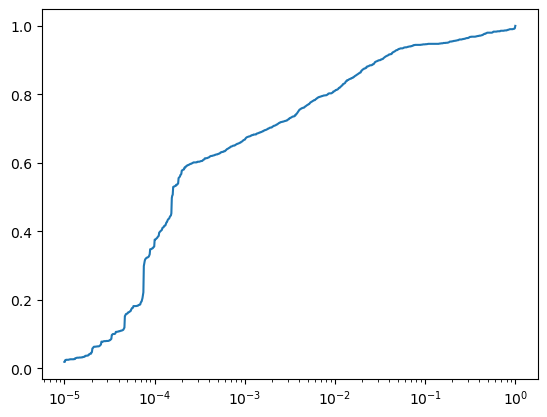

In [27]:
plot_model_sparsities(pruned_model)


In [28]:
pruned_weights, masks = prune_weights(pruned_model, epsilon)

# Assign pruned weights to the model
for weight, new_weight in zip(pruned_model.trainable_weights, pruned_weights):
    weight.assign(new_weight)

rigid_pruned_model = RigidPrunedModel(pruned_model, masks)
# rigid_pruned_model = RigidPrunedModel(CreateModel((13,21,2), n_filters=5, pool_size=3), masks)


0.6678553234844625
0.6678553234844625
0.6678553234844625
0.8099847172694855
0.9460010188487009
1.0


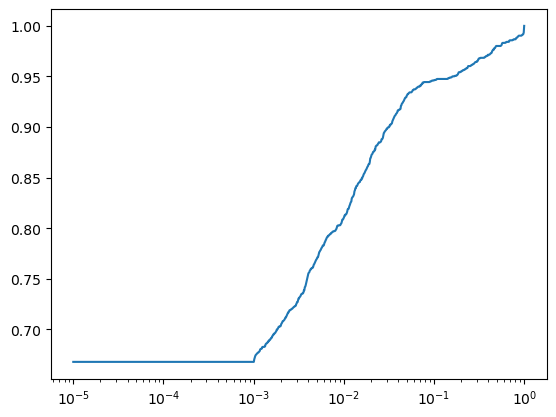

In [29]:
plot_model_sparsities(rigid_pruned_model.base_model)

In [30]:
rigid_pruned_model.compile(
    optimizer=tf.keras.optimizers.Nadam(learning_rate=1e-3),
    loss=custom_loss
)


In [31]:
os.makedirs(output_directory, exist_ok=True)
print(output_directory)

/home/das214/MDMM


In [32]:
# create tf records directory
stamp = '%08x' % random.randrange(16**8)
stamp = 1
tfrecords_dir_train = Path(output_directory, f"tfrecords_train_{stamp}").resolve()
tfrecords_dir_validation = Path(output_directory, f"tfrecords_validation_{stamp}").resolve()

tfrecords_dir_train = "/depot/cms/users/das214/tfrecords_2t_train_d8"
tfrecords_dir_validation = "/depot/cms/users/das214/tfrecords_2t_val_d8"


In [33]:
training_generator = OptimizedDataGenerator(
    load_from_tfrecords_dir = tfrecords_dir_train,
    shuffle = True,
    seed = 13,
    quantize = True
)

validation_generator = OptimizedDataGenerator(
    load_from_tfrecords_dir = tfrecords_dir_validation,
    shuffle = True,
    seed = 13,
    quantize = True
)

In [34]:
fingerprint = '%08x' % random.randrange(16**8)
os.makedirs("trained_models_rigid_pruned", exist_ok=True)
base_dir = f'./trained_models_mdmm/model-{fingerprint}-checkpoints'
os.makedirs(base_dir, exist_ok=True)  
checkpoint_filepath = base_dir + '/weights.{epoch:02d}-t{loss:.2f}-v{val_loss:.2f}.hdf5'

In [35]:
print(fingerprint)

f56e50db


In [36]:
from tensorflow.keras.callbacks import CSVLogger, EarlyStopping, ModelCheckpoint, Callback

early_stopping_patience = 50

class CustomModelCheckpoint(ModelCheckpoint):
    def on_epoch_end(self, epoch, logs=None):
        super().on_epoch_end(epoch, logs)
        checkpoints = [f for f in os.listdir(base_dir) if f.startswith('weights')]
        if len(checkpoints) > 1:
            checkpoints.sort()
            for checkpoint in checkpoints[:-1]:
                os.remove(os.path.join(base_dir, checkpoint))

es = EarlyStopping(patience=early_stopping_patience, restore_best_weights=True)

mcp = CustomModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    save_best_only=False,
    save_freq='epoch',
    verbose=1
)

csv_logger = CSVLogger(f'{base_dir}/training_log.csv', append=True)

In [ ]:
history = rigid_pruned_model.fit(
                        x=training_generator,
                        validation_data=validation_generator,
                        callbacks=[es, mcp, csv_logger],
                        epochs=1000,
                        shuffle=False,
                        verbose=1
                    )

Epoch 1/1000


2025-01-23 23:03:53.913518: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2025-01-23 23:03:54.607763: I tensorflow/core/util/cuda_solvers.cc:179] Creating GpuSolver handles for stream 0x564757b6c260
2025-01-23 23:03:56.951007: I external/local_xla/xla/service/service.cc:168] XLA service 0x7fdc1360c090 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-01-23 23:03:56.951063: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA A100-PCIE-40GB MIG 1g.5gb, Compute Capability 8.0
2025-01-23 23:03:56.961605: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1737669837.099639  465007 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


 934/1419 [==================>...........] - ETA: 1:19 - loss: -16110.4756

In [47]:
calculate_sparsity(rigid_pruned_model.base_model, epsilon = 1e-3)

0.6698930208863983

0.6678553234844625
0.6678553234844625
0.6698930208863983
0.7004584819154356
0.8166072338257768
1.0


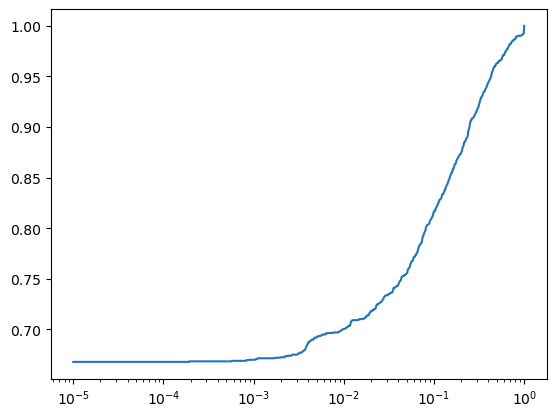

In [48]:
plot_model_sparsities(rigid_pruned_model.base_model)

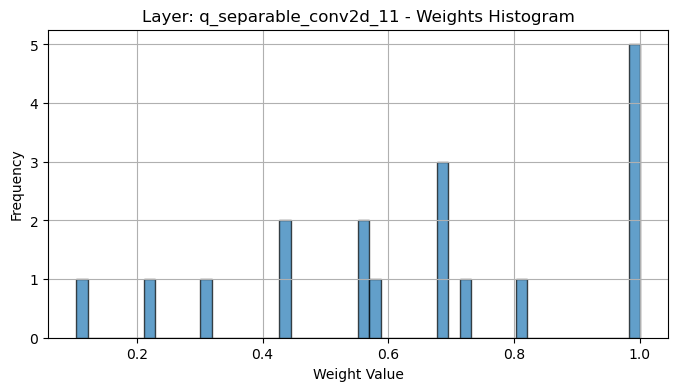

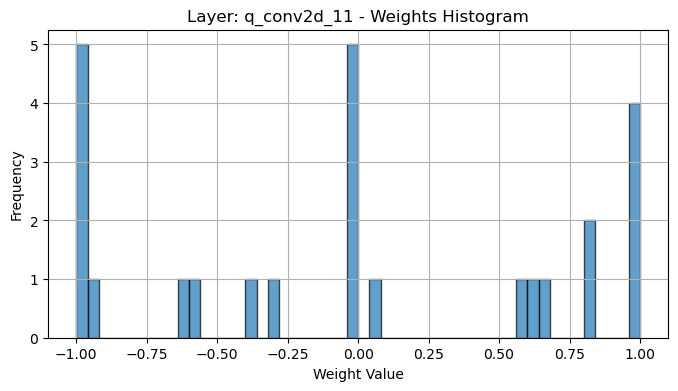

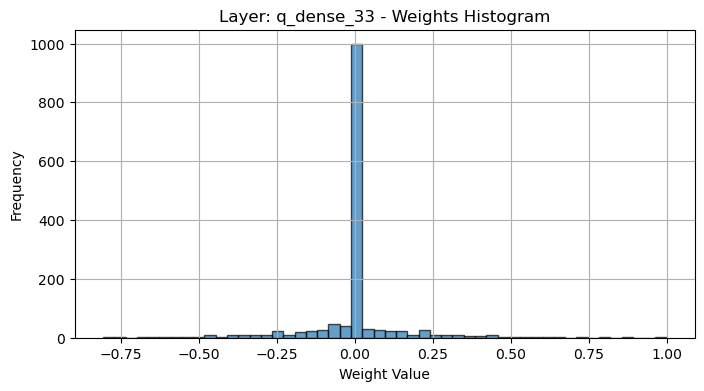

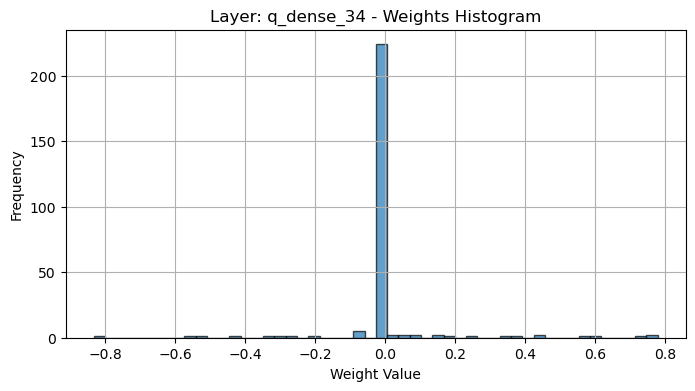

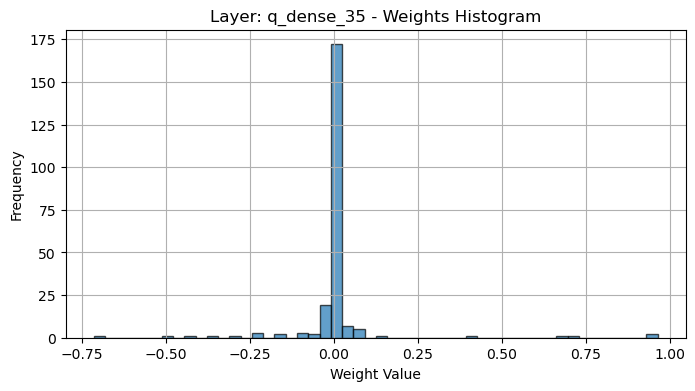

In [49]:

plot_model_weights_histograms(model = rigid_pruned_model.base_model, bins=50)

In [50]:
rigid_pruned_model.base_model

In [51]:
mdmm_model_hist_path = './trained_models_mdmm/model-076ea794-checkpoints/training_log.csv'
rigid_pruned_model_hist_path = './trained_models_mdmm/model-49ccb850-checkpoints/training_log.csv'

data1 = pd.read_csv(mdmm_model_hist_path)
data2 = pd.read_csv(rigid_pruned_model_hist_path)

In [52]:
data1['epoch'].iloc[-1]

76

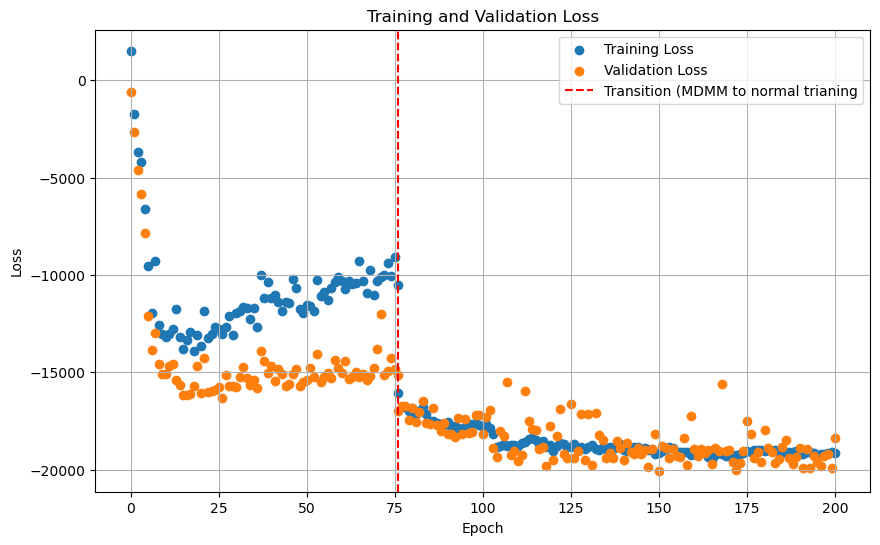

In [87]:
plt.figure(figsize=(10, 6))

color_cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
loss_color = color_cycle[0] 
val_loss_color = color_cycle[1]

plt.scatter(data1['epoch'], data1['loss'], color = loss_color, label = 'Training Loss')
plt.scatter(data1['epoch'], data1['val_loss'], color = val_loss_color, label = 'Validation Loss')

# Plot for the second file
plt.scatter(data1['epoch'].iloc[-1] + data2['epoch'], data2['loss'], color = loss_color)
plt.scatter(data1['epoch'].iloc[-1] + data2['epoch'], data2['val_loss'], color = val_loss_color)

plt.axvline(x=data1['epoch'].iloc[-1], color='red', linestyle='--', label='Transition (MDMM to normal trianing')


# Add labels, legend, and title
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid()

# Show the plot
plt.show()

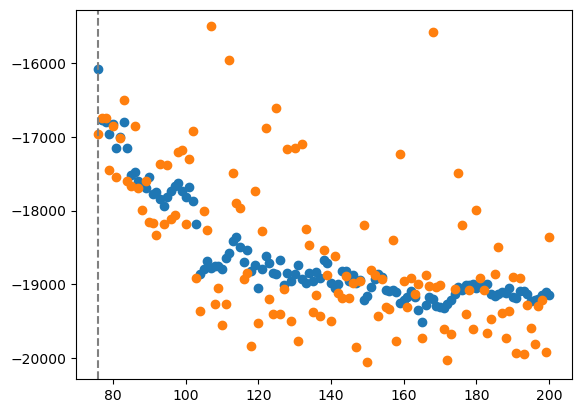

In [54]:
plt.scatter(data1['epoch'].iloc[-1] + data2['epoch'], data2['loss'], color = loss_color)
plt.scatter(data1['epoch'].iloc[-1] + data2['epoch'], data2['val_loss'], color = val_loss_color)

plt.axvline(x=data1['epoch'].iloc[-1], color='gray', linestyle='--', label='Epoch Transition')

Exception ignored in: 'read_from_file_callback'
Traceback (most recent call last):
  File "/depot/cms/kernels/python3/lib/python3.10/site-packages/matplotlib/backends/_backend_pdf_ps.py", line 164, in get_text_width_height_descent
    font.set_text(s, 0.0, flags=ft2font.LoadFlags.NO_HINTING)
OSError: [Errno 116] Stale file handle
/tmp/ipykernel_464580/445634262.py:20: UserWarning: Glyph 108 (l) missing from font(s) DejaVu Sans.
  plt.savefig("MDMM_Plot.pdf")
Exception ignored in: 'read_from_file_callback'
Traceback (most recent call last):
  File "/depot/cms/kernels/python3/lib/python3.10/site-packages/matplotlib/backends/_backend_pdf_ps.py", line 164, in get_text_width_height_descent
    font.set_text(s, 0.0, flags=ft2font.LoadFlags.NO_HINTING)
OSError: [Errno 116] Stale file handle


RuntimeError: Could not load glyph (invalid stream operation; error code 0x55)

Exception ignored in: 'read_from_file_callback'
Traceback (most recent call last):
  File "/depot/cms/kernels/python3/lib/python3.10/site-packages/matplotlib/backends/backend_agg.py", line 219, in get_text_width_height_descent
    font.set_text(s, 0.0, flags=get_hinting_flag())
OSError: [Errno 116] Stale file handle
Exception ignored in: 'read_from_file_callback'
Traceback (most recent call last):
  File "/depot/cms/kernels/python3/lib/python3.10/site-packages/matplotlib/backends/backend_agg.py", line 219, in get_text_width_height_descent
    font.set_text(s, 0.0, flags=get_hinting_flag())
OSError: [Errno 116] Stale file handle
Exception ignored in: 'read_from_file_callback'
Traceback (most recent call last):
  File "/depot/cms/kernels/python3/lib/python3.10/site-packages/matplotlib/backends/backend_agg.py", line 219, in get_text_width_height_descent
    font.set_text(s, 0.0, flags=get_hinting_flag())
OSError: [Errno 116] Stale file handle
Exception ignored in: 'read_from_file_callback

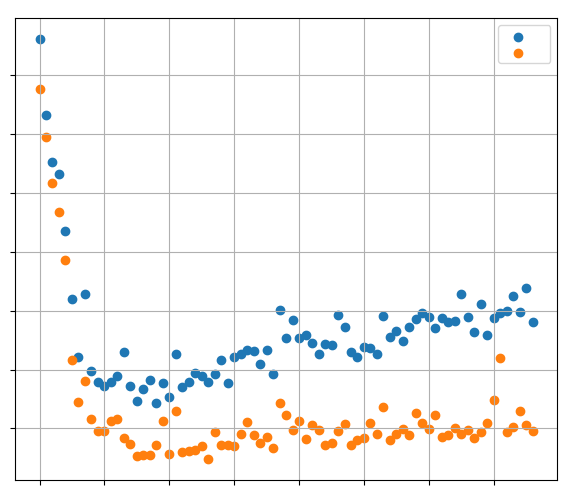

In [95]:

plt.close('all')

plt.figure(figsize=(7, 6))

color_cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
loss_color = color_cycle[0] 
val_loss_color = color_cycle[1]

plt.scatter(data1['epoch'], data1['loss'], color = loss_color, label = 'Training Loss')
plt.scatter(data1['epoch'], data1['val_loss'], color = val_loss_color, label = 'Validation Loss')

# Add labels, legend, and title
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss (MDMM)')
plt.legend()
plt.grid()

# Show the plot
plt.savefig("MDMM_Plot.pdf")
plt.show()


In [56]:
model_base_dir = f'./trained_models_mdmm/model-{fingerprint}-checkpoints'

def load_model(base_dir):
    model = CreateModel((13,21,2), n_filters=5, pool_size=3)
    model.compile(
        optimizer=tf.keras.optimizers.Nadam(learning_rate=1e-3),
        loss=custom_loss
    )
    checkpoint_files = [os.path.join(base_dir, f) for f in os.listdir(base_dir) if f.endswith('.hdf5')]
    latest_checkpoint = max(checkpoint_files, key=os.path.getmtime)
    training_cp_path = os.path.join(base_dir, 'training_log.csv')
    training_history = pd.read_csv(training_cp_path)

    print(f"Loading model from {latest_checkpoint}")
    model.load_weights(latest_checkpoint)

    return model

print(model_base_dir)
    
pruned_model_reloaded = load_model(model_base_dir)

./trained_models_mdmm/model-f56e50db-checkpoints
Loading model from ./trained_models_mdmm/model-f56e50db-checkpoints/weights.99-t-19456.30-v-18767.18.hdf5


In [57]:
pruned_model_reloaded.summary()

Model: "model_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_13 (InputLayer)       [(None, 13, 21, 2)]       0         
                                                                 
 q_separable_conv2d_12 (QSe  (None, 11, 19, 5)         33        
 parableConv2D)                                                  
                                                                 
 q_activation_60 (QActivati  (None, 11, 19, 5)         0         
 on)                                                             
                                                                 
 q_conv2d_12 (QConv2D)       (None, 11, 19, 5)         30        
                                                                 
 q_activation_61 (QActivati  (None, 11, 19, 5)         0         
 on)                                                             
                                                          

0.6678553234844625
0.6678553234844625
0.6714212939378502
0.6979113601630158
0.8155883851248089
1.0


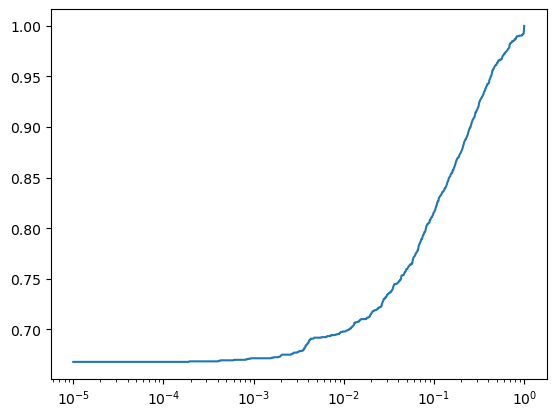

In [58]:
plot_model_sparsities(pruned_model_reloaded)

In [61]:
val_evalutaion = pruned_model_reloaded.evaluate(
    x=validation_generator, verbose=1
)

print(f"Validation Evalutation: {val_evalutaion}")


59/59 [==============================] - 4s 72ms/step - loss: -18767.1758
Validation Evalutation: -18767.17578125


In [86]:
def calculate_exact_sparsity(model):
    for l in model.layers:
        if l.weights:
            weights = l.get_weights()[0]
            weights = np.ndarray.flatten(weights)
    
            count = 0
            for w in weights:
                if w == 0:
                    count += 1
            
            print(f" zero count: {count}, total num weights: {len(weights)}, sparsity: {count/len(weights):.2f} %")

calculate_exact_sparsity(pruned_model_reloaded)

 zero count: 0, total num weights: 18, sparsity: 0.00 %
 zero count: 5, total num weights: 25, sparsity: 0.20 %
 zero count: 948, total num weights: 1440, sparsity: 0.66 %
 zero count: 217, total num weights: 256, sparsity: 0.85 %
 zero count: 141, total num weights: 224, sparsity: 0.63 %


In [77]:
90*16

1440